In [71]:
import os, importlib, sys, time

In [72]:
import numpy as np
import pandas as pd

In [73]:
import matplotlib.pyplot as plt
plt.rc('font', size=10)

In [74]:
import scipy.linalg as la
import scipy.stats as stats
import scipy.optimize as opt

In [75]:
import freqepid

# 1. parameters

In [76]:
GPi = np.load('data/GPi.npz')

In [96]:
param = pd.read_feather('data/param_ebcr_2.feather')
thetas = param.iloc[:,-3:].to_numpy()

In [97]:
regions = param.region.to_numpy()
num_region = len(regions)
d = thetas.shape[-1]-1

(array([ 7., 19., 16.,  4.,  1.,  0.,  6., 21., 17.,  9.]),
 array([-2.85720973, -2.68563452, -2.51405932, -2.34248412, -2.17090891,
        -1.99933371, -1.82775851, -1.6561833 , -1.4846081 , -1.3130329 ,
        -1.14145769]),
 <BarContainer object of 10 artists>)

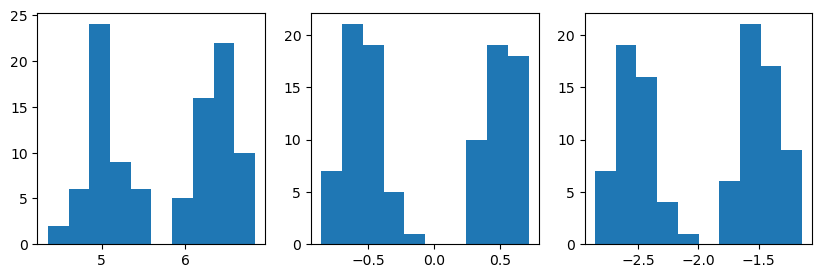

In [98]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.hist(thetas[:,0])
plt.subplot(1,3,2); plt.hist(thetas[:,1])
plt.subplot(1,3,3); plt.hist(thetas[:,2])

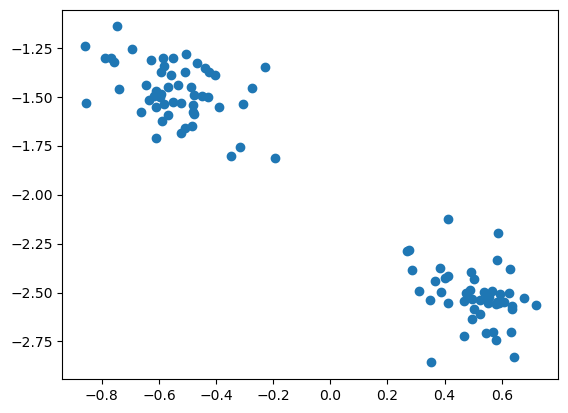

In [99]:
plt.scatter(thetas[:,1], thetas[:,2])

# 2. simulation

## load simulation

In [100]:
data = pd.read_feather('data/simulation_ebcr_2.feather')

In [101]:
data

,region,date,R,EI,infection,EY,death,intervention
0,aa,0,3.83775,614.461723,614.461723,1.530772,1,0
1,aa,1,3.83775,646.418102,646.418102,1.541138,2,0
2,aa,2,3.83775,764.782524,764.782524,1.550349,1,0
3,aa,3,3.83775,958.980489,958.980489,1.559102,1,0
4,aa,4,3.83775,1220.648612,1220.648612,1.569473,3,0
...,...,...,...,...,...,...,...,...
5926,dv,57,0.88899,23847.672976,23847.672976,341.600895,134,1
5927,dv,58,0.88899,23457.591709,23457.591709,337.524570,400,1
5928,dv,59,0.88899,23073.891081,23073.891081,333.310910,178,1
5929,dv,60,0.88899,22696.466723,22696.466723,328.921328,222,1


# 3. Fit results

In [102]:
model = freqepid.Model(GPi['g'], GPi['pi'], T0=40, family='nbinom')

In [103]:
result = pd.read_feather('result_epidemia_ebcr_2.feather')

In [104]:
ths_smp = np.stack([
    np.stack([
        np.log(result['seeds[%s]'%r]),
        result['R|(Intercept)'] 
           + result['R|b[(Intercept) region:%s]'%r],
        result['R|intervention'] 
           + result['R|b[intervention region:%s]'%r]
    ], 0)
    for r in regions
], 0)

In [105]:
ths_epi = np.mean(ths_smp, -1)

In [106]:
covs_epi = np.stack([
    np.cov(th_smp) for th_smp in ths_smp
])

## plot

In [107]:
chi_pa = freqepid.CV(d).chi_pa(0.05)

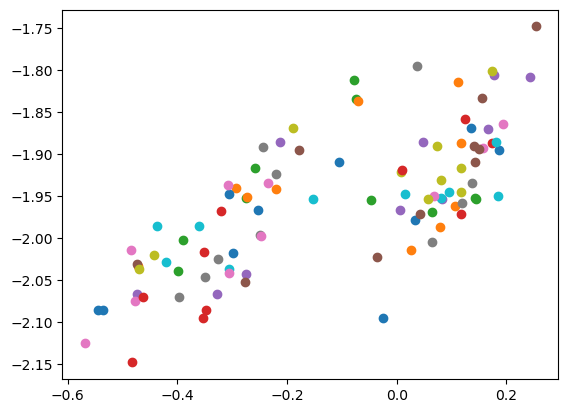

In [108]:
for i_region, (theta, th_epi, cov_epi) in enumerate(zip(thetas, ths_epi, covs_epi)):
    p = plt.scatter(*(th_epi[1:]))
#     plt.arrow(*theta[1:], *(th_epi[1:]-theta[1:]), width=0.005, 
#               length_includes_head=True,
#               color=p.get_facecolor(), alpha=1)
#     freqepid.confidence_ellipse(
#         th_epi[1:], cov_epi[1:,1:], n_std = chi_pa,
#         facecolor=p.get_facecolor(), alpha=0.3)

(-4.0, 0.0)

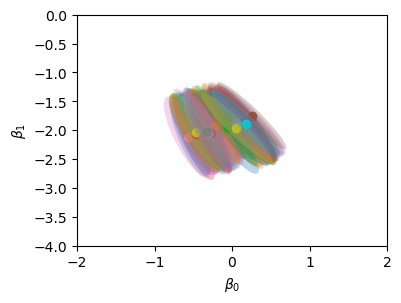

In [117]:
plt.figure(figsize=(4,3))
for i_region, (theta, th_epi, cov_epi) in enumerate(zip(thetas, ths_epi, covs_epi)):
    p = plt.scatter(*(th_epi[1:]))
#     plt.arrow(*theta[1:], *(th_epi[1:]-theta[1:]), width=0.005, 
#               length_includes_head=True,
#               color=p.get_facecolor(), alpha=1)
    freqepid.confidence_ellipse(
        th_epi[1:], cov_epi[1:,1:], n_std = chi_pa,
        facecolor=p.get_facecolor(), alpha=0.3)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$")
plt.xlim([-2, 2]); plt.ylim([-4, 0])

In [110]:
X2_epi = ((ths_epi[:,1:] - thetas[:,1:])[:,None,:] @ np.linalg.pinv(covs_epi[:,1:,1:]) @ (ths_epi[:,1:] - thetas[:,1:])[:,:,None])[:,0,0]

In [111]:
np.mean(X2_epi < chi_pa**2)

0.63

In [112]:
X2_epi = ((ths_epi[:,2:] - thetas[:,2:])[:,None,:] @ np.linalg.pinv(covs_epi[:,2:,2:]) @ (ths_epi[:,2:] - thetas[:,2:])[:,:,None])[:,0,0]

In [113]:
np.mean(X2_epi < freqepid.CV(1).chi_pa(0.05)**2)

0.34

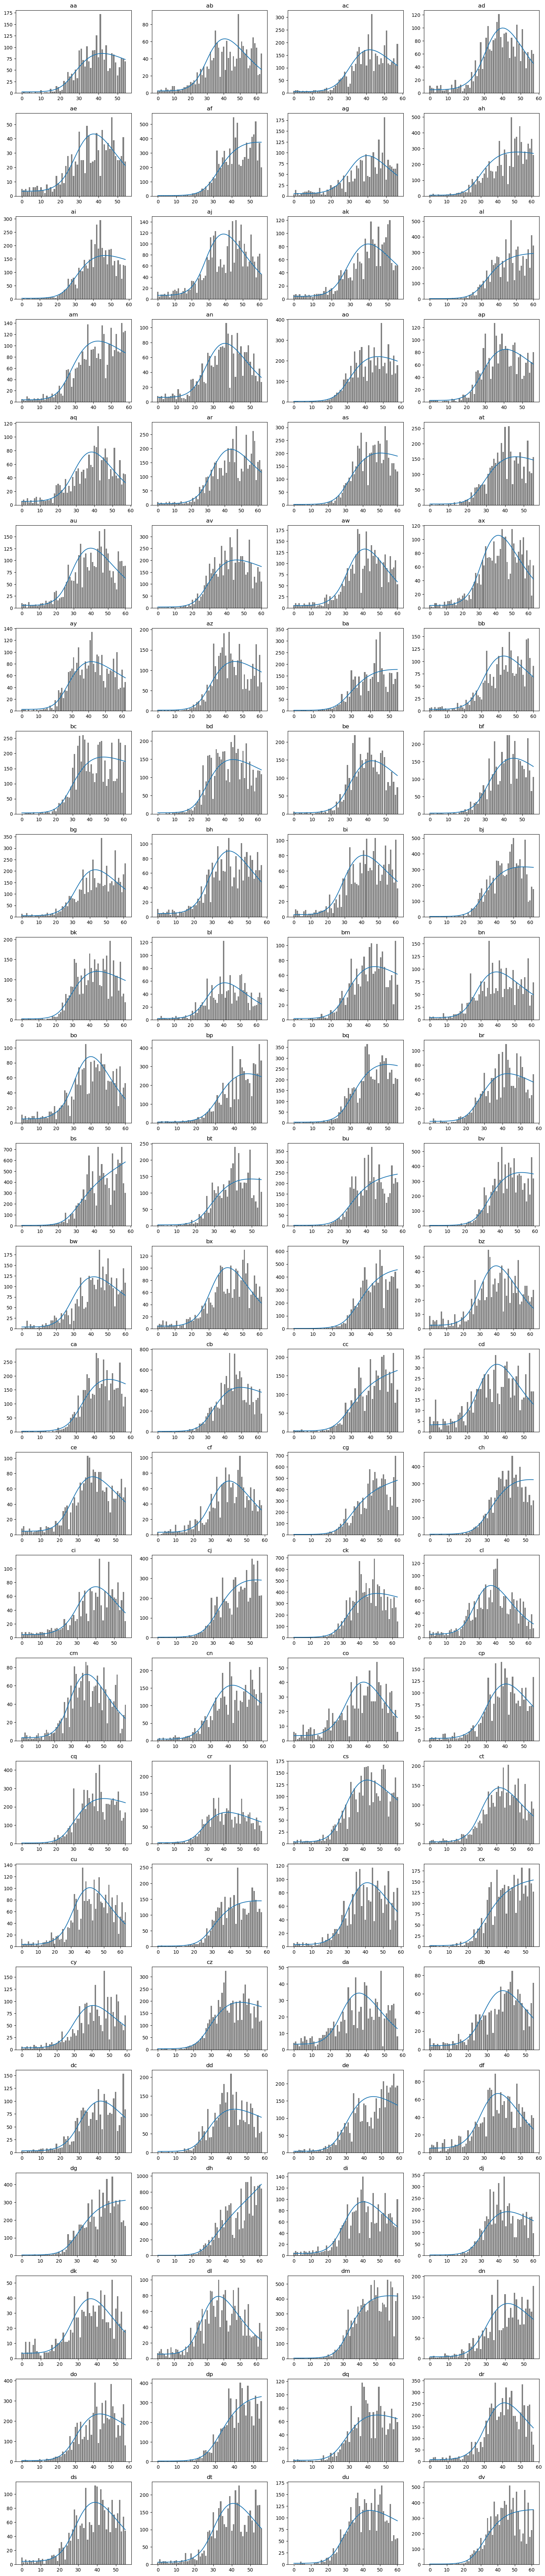

In [ ]:
plt.figure(figsize=(16, int(num_region/4+1)*3))

for i, r in enumerate(regions):
    plt.subplot(int(num_region/4+1),4,i+1)
    
    Y = np.array(data[data.region == r].death)
    T = Y.shape[0]
    
    A = np.zeros([T, d])
    A[:,0] = np.full(T, 1)
    A[:,1:] = np.array(data[data.region == r].intervention)[:,None]

    plt.bar(np.arange(T), Y, color='grey')
    plt.plot(model.predict_EY(A, ths_epi[i,0], ths_epi[i,1:]))
    plt.title('%s'%r)
    
plt.tight_layout()